# Decision Trees and Random Forests

In this section of the project, we are going to continue to use the 2022 baseball season to predict wOBA values for balls in play. As a reminder, wOBA is an on-base percentage that accounts for how a player reached base with each event corresponding to a different wOBA value. Home runs have the highest wOBA value and an out has the lowest wOBA value. In order to predict wOBA values, launch angle and launch velocity will be the two variables examined.

In the last section, a K-nearest neighbor model was used to predict wOBA values and in this section, a Decision Tree and a Random Forest will be built to predict wOBA values. Once the models are built, they will be assessed and compared to the K-nearest neighbor model to determine which model is the best at predicting wOBA values. 

## Data Collection
To begin, the 2022 baseball season will be imported below. Once, the data is loaded, the column names will be printed out in order to determine our primary key. We will use a primary key later in the project which will allow us to join the main data table to our model. The columns that will be used to create the primary key are game_pk, at_bat_number, and pitch_number because they create a unique event when combined. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pybaseball import statcast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import log_loss
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [2]:
stat_df = statcast(start_dt="2022-04-07", end_dt="2022-10-02")

This is a large query, it may take a moment to complete


  0%|                                                                                          | 0/179 [00:00<?, ?it/s]C:\Users\AGaev\AppData\Local\Programs\Python\Python311\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  1%|▍                                                                                 | 1/179 [00:20<59:36, 20.09s/it]C:\Users\AGaev\AppData\Local\Programs\Python\Python311\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  1%

In [3]:
#To create a unique key
stat_df["primary_key"] = [str(x) + "_" + str(y) + "_" + str(z) for x, y, z in zip(stat_df["game_pk"], stat_df["at_bat_number"], stat_df["pitch_number"])]
stat_df[["primary_key","game_pk", "at_bat_number", "pitch_number"]]

,primary_key,game_pk,at_bat_number,pitch_number
2712,663419_78_6,663419,78,6
2826,663419_78_5,663419,78,5
2905,663419_78_4,663419,78,4
3038,663419_78_3,663419,78,3
3155,663419_78_2,663419,78,2
...,...,...,...,...
1734,661042_1_5,661042,1,5
1824,661042_1_4,661042,1,4
1890,661042_1_3,661042,1,3
1903,661042_1_2,661042,1,2


In [4]:
#Exit Velocity and Launch Angle
bip_df = stat_df[(pd.notnull(stat_df["bb_type"]))]
bip_df = bip_df.dropna(how="any", subset=["launch_speed", "launch_angle"])
list(set(bip_df["description"]))

['hit_into_play']

In [5]:
bip_df["ev_round"] = [round(ev) for ev in bip_df["launch_speed"]]
bip_df["la_round"] = [round(la) for la in bip_df["launch_angle"]]

### Visualize the Data
Below is a scatter plot of exit velocity and launch angle with wOBA values displayed in a coolwarm color scale. Red indicates a high wOBA value and blue is a low wOBA value. In the graph, the high wOBA values which are likely home runs occur when the exit velocity is between ~100-120mph and a launch angle of ~20-50 degrees. 

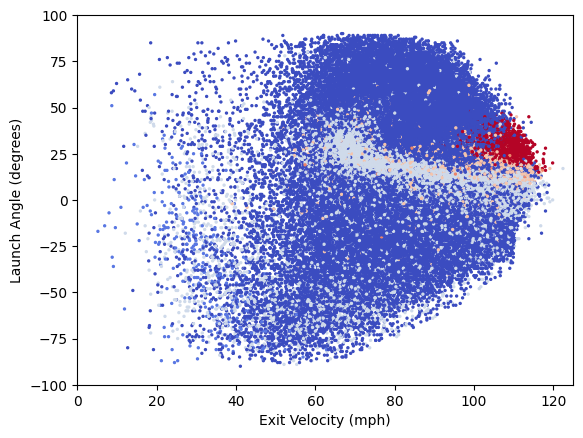

In [6]:
#Plot of the Data with wOBA values on a coolwarm color scale
fig, ax = plt.subplots()
plt.scatter(x=bip_df["launch_speed"], y=bip_df["launch_angle"], c=bip_df["woba_value"], s=2, cmap="coolwarm")
ax.set_xlim(0,125)
ax.set_ylim(-100,100)
ax.set_xlabel("Exit Velocity (mph)")
ax.set_ylabel("Launch Angle (degrees)")
plt.show()

A new table is created below which only includes the necessary columns for this model. The columns that will be used are launch_speed, launch_angle, events, and primary_key. 

In [7]:
bip_df.isnull().values.any()

# Identify rows with NaN values
rows_with_nan = bip_df[bip_df.isnull().any(axis=1)]
 
#View the rows with NaN values
print(rows_with_nan)

#New Data table that includes Launch Speed, Launch Angle, and Events
#Make sure to add the columns needed for the primary key to the below code
ev_la_df = bip_df[["launch_speed", "launch_angle", "events","primary_key"]]

ev_la_df

     pitch_type  game_date  release_speed  release_pos_x  release_pos_z  \
3428         ST 2022-10-02           78.4           1.95           5.71   
4151         CH 2022-10-02           78.8           1.86            5.8   
2451         FF 2022-10-02           96.9          -2.12           5.78   
3660         FF 2022-10-02           98.5          -2.23           5.78   
1369         SI 2022-10-02           92.9           1.98           5.41   
...         ...        ...            ...            ...            ...   
1470         SI 2022-04-07           92.9           0.96           5.98   
1984         SI 2022-04-07           94.2           0.84           6.14   
999          FF 2022-04-07           98.0           -2.0           5.95   
1384         FF 2022-04-07           97.7          -1.83           5.94   
1688         FF 2022-04-07           99.0          -2.01            5.9   

          player_name  batter  pitcher                     events  \
3428   Zastryzny, Rob  608369 

,launch_speed,launch_angle,events,primary_key
3428,54.2,37,field_out,663419_77_5
4151,95.1,25,field_out,663419_76_3
2451,100.5,0,grounded_into_double_play,663419_75_5
3660,88.6,39,field_out,663419_73_6
1369,97.1,4,single,663419_67_4
...,...,...,...,...
1470,80.2,-26,grounded_into_double_play,661042_8_4
1984,88.7,-53,field_out,661042_6_1
999,81.5,64,field_out,661042_5_2
1384,80.7,-34,force_out,661042_3_5


## Model Build

Just like we did in the K-nearest neighbors model, in this section, each event is indexed from 0 to 5. For example, an out is 0 and a single is 1. Then the data is split into a training and test set with 75% of the data in the training set and 25% in the test set. Splitting the data into a training and test set is important because it allows us to assess how well the model performs on unseen data in the test set. 

In [8]:
#Categorize the events: Out, Single, Double, Triple, and Home Run
ev_la_df = ev_la_df[ev_la_df["events"].isin(["field_out", "single", "double", "triple", "home_run"])]
ev_la_df["events_encoded"] = [0 if x == "field_out" 
                                  else 1 if x == "single" 
                                  else 2 if x == "double" 
                                  else 3 if x == "triple" 
                                  else 4 if x == "home_run" 
                                  else 5 for x in ev_la_df["events"]]


# Split the data into features (X) and target (y)
X = ev_la_df.drop("events_encoded", axis=1)
Y = ev_la_df["events_encoded"]

# Split the data into training and test sets: 75% of the data is for training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state =1)

C:\Users\AGaev\AppData\Local\Temp\ipykernel_6412\2880259879.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_la_df["events_encoded"] = [0 if x == "field_out"


Now that the data is split, it will be scaled because the model is distance based and we do not want the magnitude of one variable to affect the model. As a result, launch speed and launch angle will be on the same scale.

In [9]:
#Scale the data
scaler= StandardScaler()
features = ["launch_speed", "launch_angle"]
X_train = scaler.fit_transform(X_train[features])
X_test = scaler.transform(X_test[features])

Next, the model will be fitted. When viewing the output, the index of 0 corresponds to launch speed and 1 corresponds to launch angle. When reading the decision tree, a true statement goes to the left branch and a false statement goes to the right branch. 

Let's walk through an example:
At the top of the tree, it asks whether the launch angle is less than or equal to 0.6 which is in scaler form. If the answer is yes, then we move down the branch on the left. If the answer is no, then we move down the branch on the right to the next node. We continue this pattern until we get to the last node at the bottom of our decision tree. 


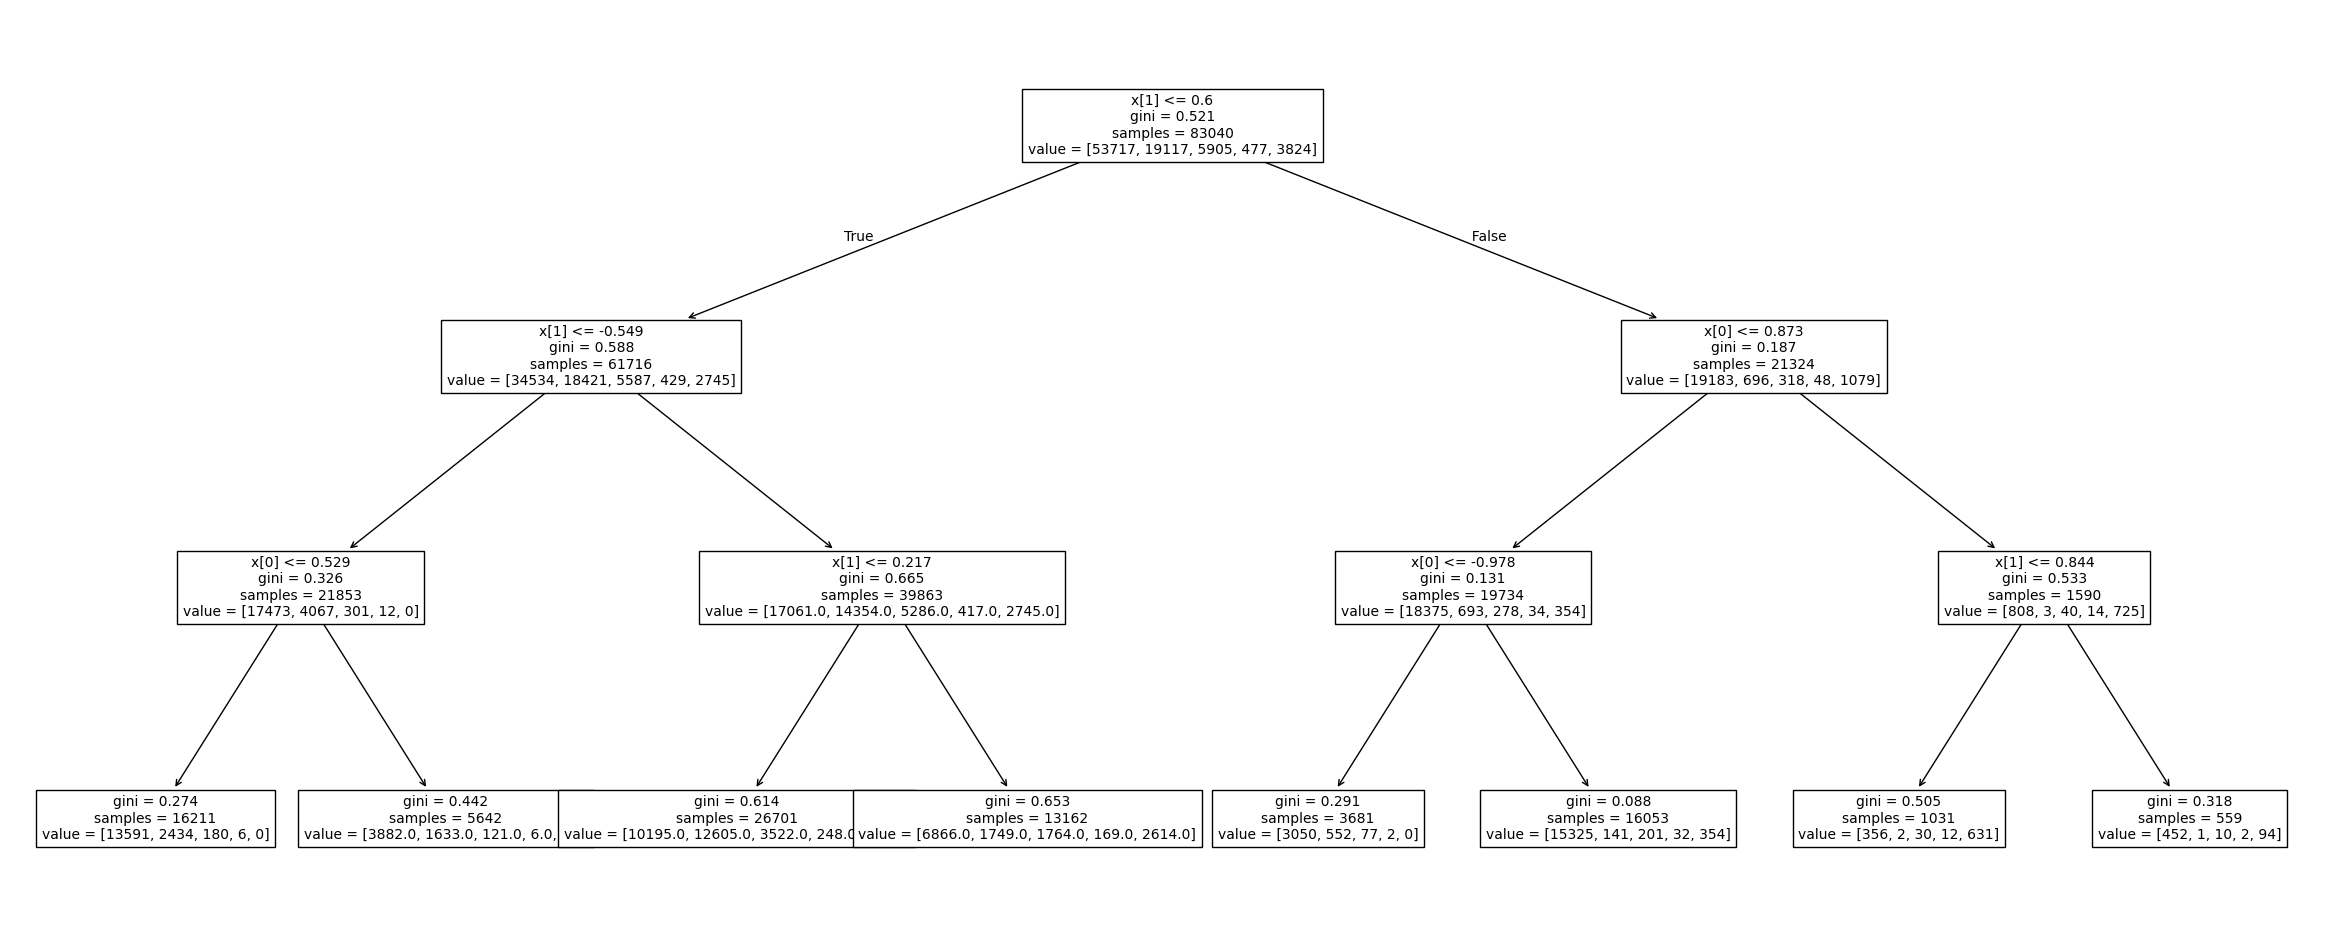

In [10]:
#Fit model
# index of 0 is launch_speed and 1 is launch_angle
decision_tree = DecisionTreeClassifier(min_samples_leaf=100, max_depth=3)
decision_tree.fit(X_train, Y_train)

#Show Tree
plt.figure(figsize = (30,12))
tree.plot_tree(decision_tree, fontsize = 10)
plt.show()

The below code goes over an example.

__Example__: If launch speed = 1 and launch angle = 0.7 (both in scaler form). Let's convert this point from scaler form to original form and this can be done with the scaler.inverse_transform function. So the point (1,0.7) corresponds to (103.00016 mph, 34.376 degrees). With this launch speed and angle, the probability it's an out is 34.53%, single 0.194%, double 2.91%, triple 1.16%, and home run 61.20%. So, this data point is most likely a home run or an out. 

In [11]:
test_df = pd.DataFrame({"launch_speed": [1], "launch_angle": [0.7]})
test_df

,launch_speed,launch_angle
0,1,0.7


In [12]:
decision_tree.predict_proba(test_df)

C:\Users\AGaev\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


array([[0.34529583, 0.00193986, 0.02909796, 0.01163919, 0.61202716]])

In [13]:
original_point = scaler.inverse_transform(test_df)
original_point

array([[103.00016259,  34.37640541]])

__Below is an example of scaling__

In Original form:
Launch Speed = 130 
Launch Angle = 30 

In scaled form:
Launch Speed = 2.8578
Launch Angle = 0.5476

This means that a launch speed of 130 mph is about 2.86 standard deviations vs average and a launch angle of 30 degrees is about 0.55 standard deviations vs average. 

In [14]:
test_df = pd.DataFrame({"launch_speed": [130], "launch_angle": [30]})
test_df

,launch_speed,launch_angle
0,130,30


In [15]:
scaled_point = scaler.transform(test_df)
scaled_point

array([[2.85777112, 0.54761733]])

In [16]:
decision_tree.predict_proba(scaled_point)

array([[0.52165324, 0.13288254, 0.13402219, 0.01283999, 0.19860204]])

In [17]:
preds_test = decision_tree.predict_proba(X_test)
preds_test

array([[0.95465022, 0.0087834 , 0.01252102, 0.0019934 , 0.02205195],
       [0.80858676, 0.00178891, 0.01788909, 0.00357782, 0.16815742],
       [0.52165324, 0.13288254, 0.13402219, 0.01283999, 0.19860204],
       ...,
       [0.38182091, 0.4720797 , 0.13190517, 0.00928804, 0.00490618],
       [0.38182091, 0.4720797 , 0.13190517, 0.00928804, 0.00490618],
       [0.95465022, 0.0087834 , 0.01252102, 0.0019934 , 0.02205195]])

## Calibration Curves for Each Event

In [18]:
#Calibration Curve for Each Event
def plot_calibration_curve(y_test, target_class, preds):
    """ This function ingests a target variable
    and predicted probabilities to generate
    a calibration cure

    @param y_test: This list contains the multiclass target
      for our hit type model
    @param target_class: Integer corresponding to one target
       in the y_test list
    @param preds: Numpy array of predicted probabilities for
       each target class in y_test
    
    Returns:
    
       -fig: Matplotlib object calibration curve
    """
    #Convert multiclass target to binary based on target class
    binary_target = [1 if y==target_class else 0 for y in y_test]
    
    # Initialize visualizaton
    fig = plt.figure(1, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

    fraction_of_positives, mean_predicted_value = \
    calibration_curve(binary_target, preds [:,target_class], n_bins=10)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-")
    ax1.set_xlabel("Predicted Frequency")
    ax1.set_ylabel("Observed Frequency")
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    plt.close ()
    
    return fig

In [19]:
fig_list = []
for target in range(0,5):
    fig = plot_calibration_curve(y_test = Y_test,target_class = target,preds = preds_test)
    fig_list.append(fig)

## Calibration Curve for an Out

In the calibration curve for an out, one can see that the blue line looks very similar to the dotted line, almost inline with it. This means that the model is very good at predicting outs, especially when the predicted frequency is above 0.4. However, when the predicted frequency is below 0.4, the model is unable to predict the low frequency points. Since the model only includes exit velocity and launch angle, it makes sense that it has difficulty predicting lower frequency points given park size and additional variables are not included in the model.

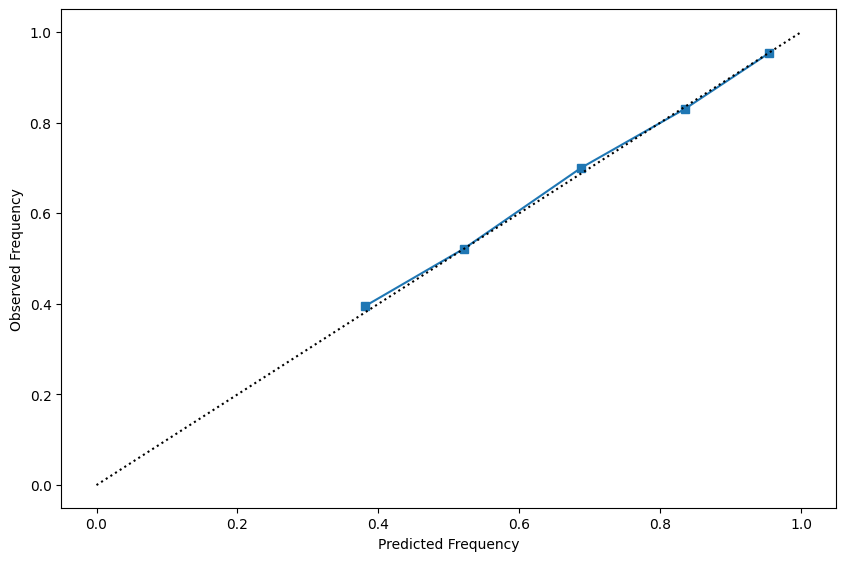

In [20]:
fig_list[0]

## Calibration Curve for a Single

Below is a calibration curve for a single. One can see that the blue line looks very similar to the dotted line, almost inline with it (fully calibrated). However, when the predicted frequency is above 0.5, the model is unable to predict the higher probability points. 

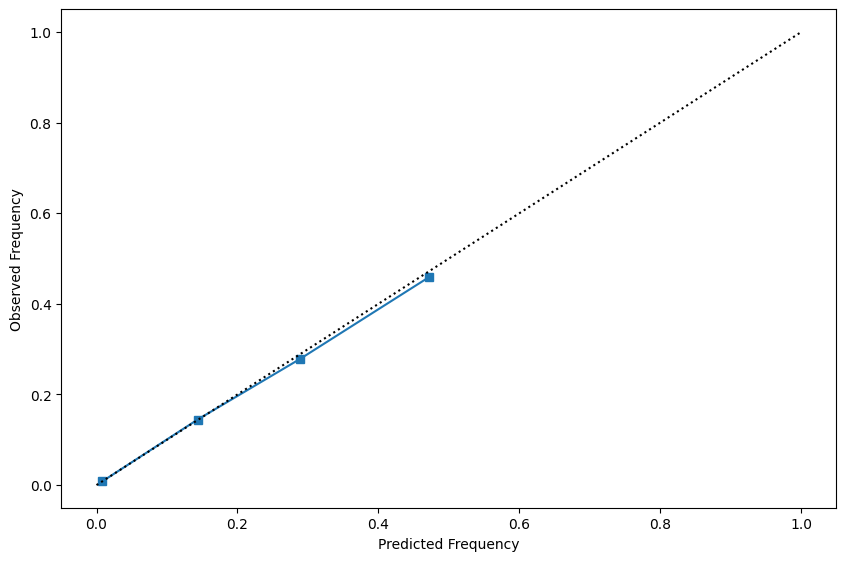

In [21]:
fig_list[1]

## Calibration Curve for a Double

The calibration curve for a double shows that the blue and dotted line are inline when the predicted frequencey is between 0 and 0.2. This makes sense because it is difficult to discern the difference between a single and double when looking at launch speed and launch angle. The speed of the batter running the bases can impact whether a hit is a single or double. Additionally, doubles are rarer than singles. 

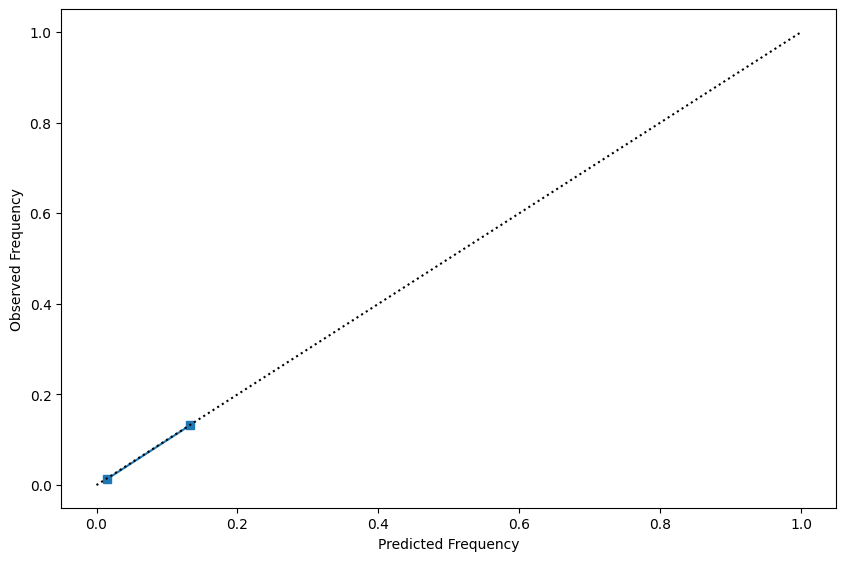

In [22]:
fig_list[2]

## Calibration Curve for a Triple

Just as we saw in the k nearsest neighbors calibration curve for a triple, the decision tree's calibration curve for a triple is a single point which is due to the fact that hitting a triple in baseball is rare. Thus, there is not a lot of data for the model to learn off of, making it difficult to predict triples. Additionally, a batter's speed around the bases is also a factor in whether the outcome is a triple. For example, a fast batter can extend a double into a triple.

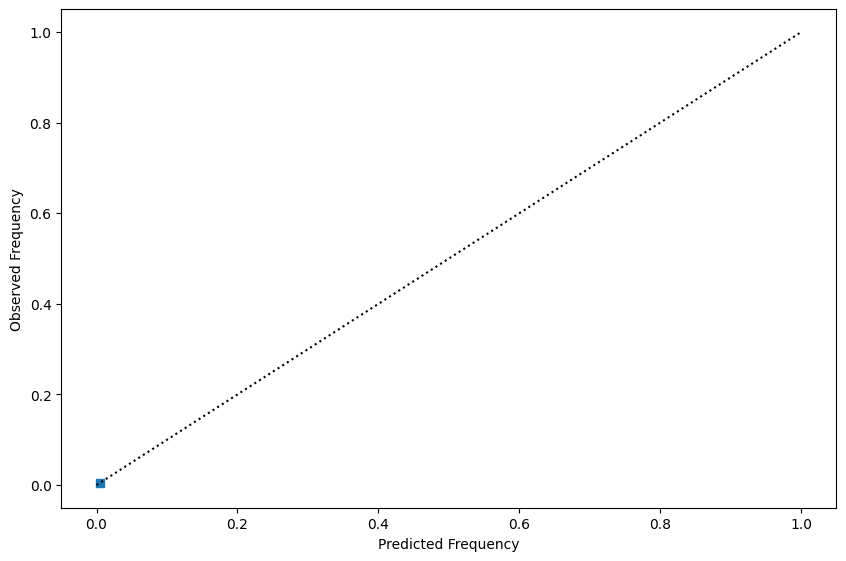

In [23]:
fig_list[3]

## Calibration Curve for a Home Run

Similar to the other calibration curves, the blue line is close to the dotted line and almost inline. This means that the model is pretty good at predicting home runs but is not perfect. When the predicted frequency is above 0.6, the model is unable to predict those higher frequency data points.

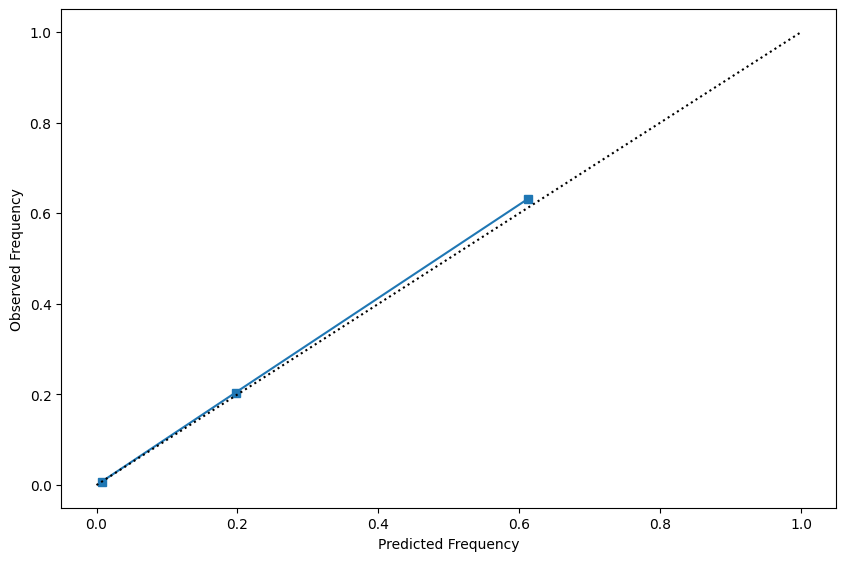

In [24]:
fig_list[4]

## Random Forest

Now we are going to explore another type of model, the random forest. A random forest is a model that is composed of multiple decision trees. 

To begin, we are going to leverage cross validation through gridsearchcv which will find the best values for n_estimators, min_samples_leaf, and max_depth. These values are a max_depth of 5, min_samples_leaf of 150 and n_estimators of 100. 

In [25]:
rf_classifier = RandomForestClassifier()
#create a dictionary of all values we want to test for 
param_grid = {'n_estimators': (100,200,300), 'min_samples_leaf':(50,100,150), 'max_depth':(3,4,5)}
#use gridsearch to test all values for n_neighbors
rf_classifier_gscv = GridSearchCV(rf_classifier, param_grid, cv=5)
#fit model to data
rf_classifier_gscv.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': (3, 4, 5),
                         'min_samples_leaf': (50, 100, 150),
                         'n_estimators': (100, 200, 300)})

In [26]:
rf_classifier_gscv.best_estimator_

RandomForestClassifier(max_depth=5, min_samples_leaf=150)

In [27]:
rf_classifier_gscv.best_estimator_.n_estimators

100

Feature importance: launch speed is 29.5% and launch angle is 70.5%. This represents the importance of the features in minimizing the gini index. The gini index is a measure that indicates how mixed or impure a dataset is and how likely labels are misclassified when randomly assigned, thus minimizing the gini index is important. 

In [28]:
# feature that minimizes the gini index. When splitting, launch angles makes up roughly 2/3 of importance when minimizing the gini index
rf_classifier_gscv.best_estimator_.feature_importances_

array([0.2950534, 0.7049466])

In [29]:
rf_test_df = pd.DataFrame({"kick_distance": [1], "launch": [0.7]})  
rf_test_df

,kick_distance,launch
0,1,0.7


In [30]:
rf_classifier_gscv.predict_proba(rf_test_df)

C:\Users\AGaev\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([[0.41712655, 0.01223654, 0.07676553, 0.01401742, 0.47985396]])

Below preds_test is created to show the probablities of each event for every data point within X_test. For example, the first data point has a probability of 91.21% for an out, 3.22% for a single, 2.15% for a double, 0.302% for a triple, and 3.11% for a home run.

In [31]:
rf_preds_test = rf_classifier_gscv.predict_proba(X_test)
rf_preds_test

array([[0.91207948, 0.03222195, 0.02154399, 0.00301649, 0.0311381 ],
       [0.63686171, 0.00557587, 0.04154289, 0.00795157, 0.30806796],
       [0.44370755, 0.05964652, 0.17458401, 0.01786329, 0.30419863],
       ...,
       [0.48191786, 0.42792057, 0.08170199, 0.00638366, 0.00207592],
       [0.41282051, 0.45900729, 0.1122511 , 0.0093433 , 0.0065778 ],
       [0.88432737, 0.05425411, 0.02262481, 0.00351463, 0.03527908]])

## Calibration Curves for Each Event

In [32]:
fig_list = []
for target in range(0,5):
    fig = plot_calibration_curve(y_test = Y_test,target_class = target,preds = rf_preds_test)
    fig_list.append(fig)

## Calibration Curve for an Out

In the calibration curve for an out, one can see that when the predicted frequency is below 0.6, the model is over predicting and when the predicted frequency is above 0.6, the model is under predicting. 

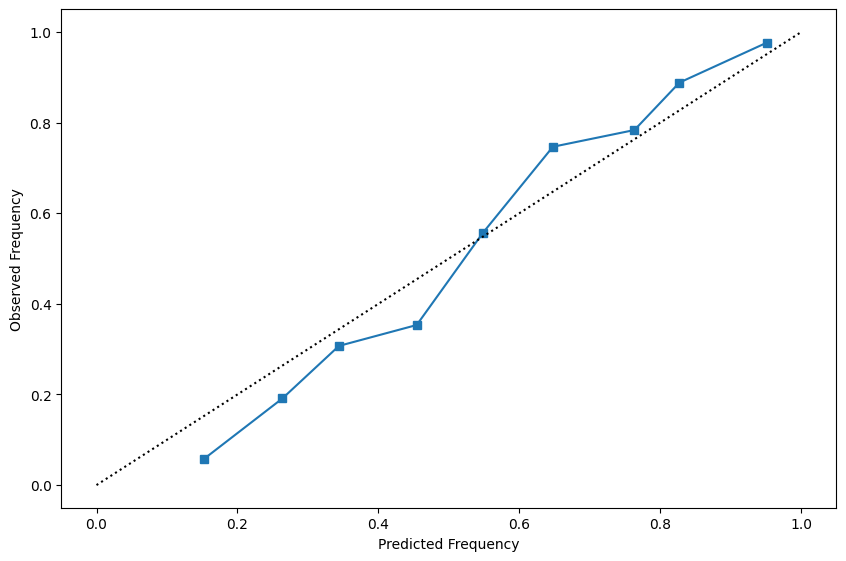

In [33]:
fig_list[0]

## Calibration Curve for a Single

For a single, when the predicted frequency is below 0.4, the blue line is close to the dotted line but the model is over predicting. When the predicted frequency is above 0.6, the model is under predicting. 

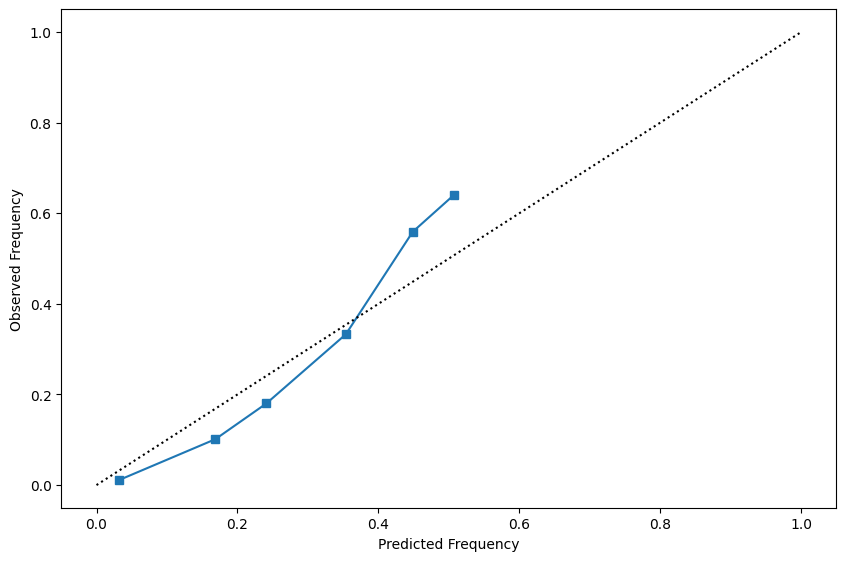

In [34]:
fig_list[1]

## Calibration Curve for a Double

For a double, the blue line is inline with the dotted line when the predicted frequency is below 0.2. When the predicted frequency is above 0.2, model is under predicting.

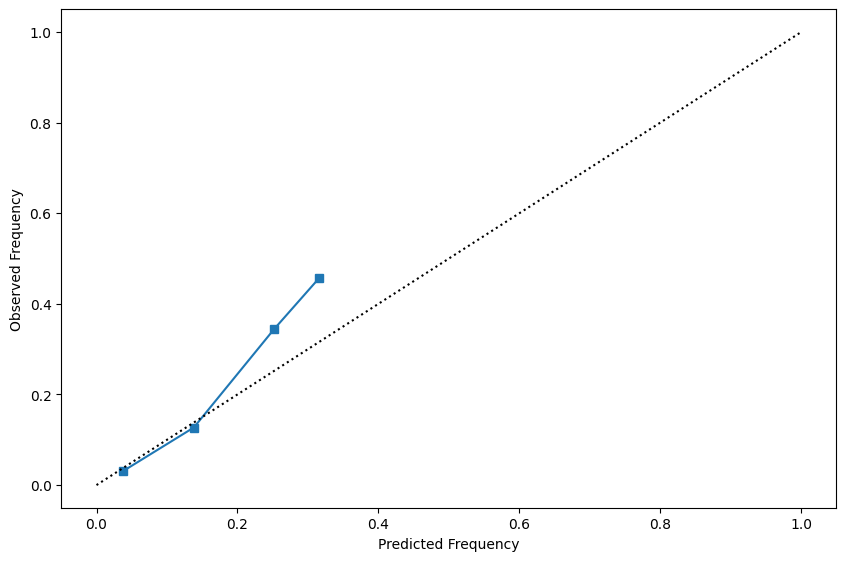

In [35]:
fig_list[2]

## Calibration Curve for a Triple

As we saw in the previous model type, the calibration curve for a triple is a single point which is due to the fact that hitting a triple in baseball is rare. Thus, there is not a lot of data for the model to learn off of, making it difficult to predict triples. Additionally, a batter's speed around the bases is also a factor in whether the outcome is a triple. For example, a fast batter can extend a double into a triple.

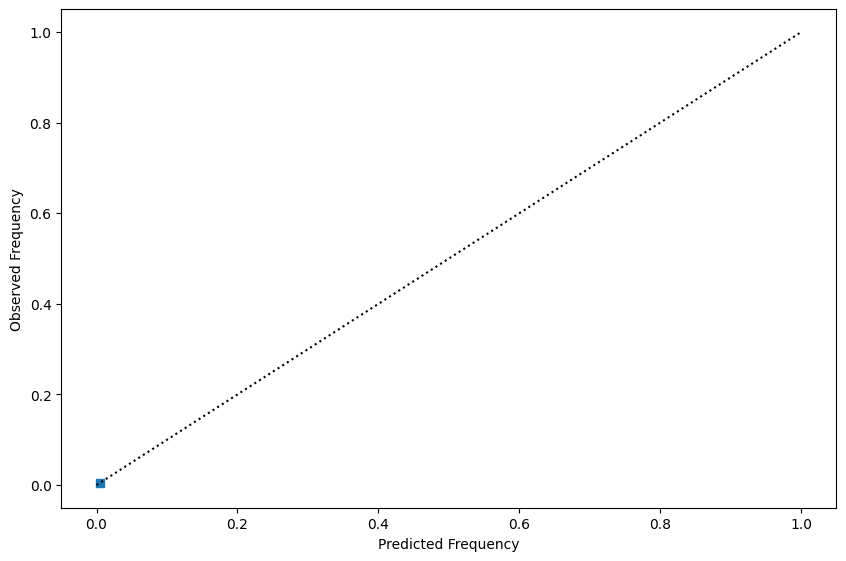

In [36]:
fig_list[3]

## Calibration Curve for a Home Run

For a home run, the model is under predicting when the predicted frequency is above 0.2. This can be due to home runs being less common and park dimensions having an impact on whether a hit is a home run or not. 

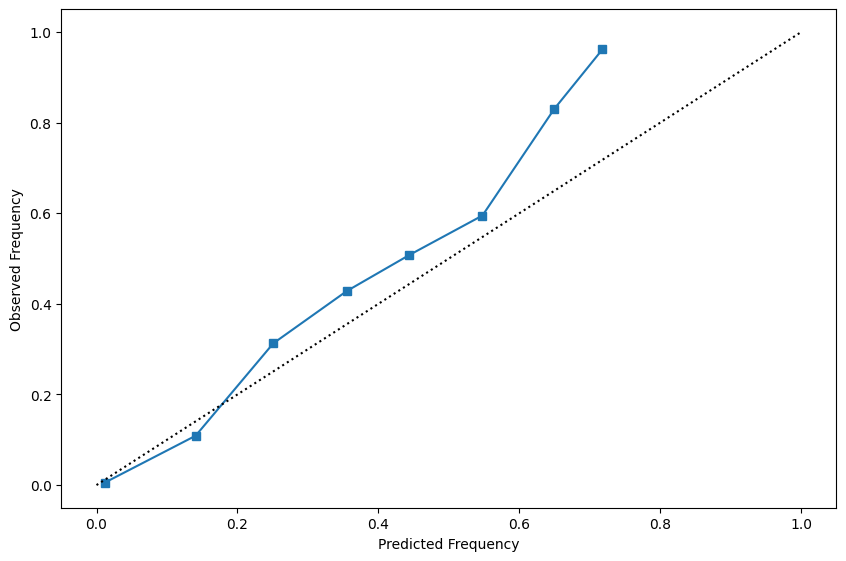

In [37]:
fig_list[4]

## Data Exploration

The below chart shows the probability of each event for each data point. For example, the first point in the chart shows that with a launch speed of 0.21 and launch angle of 0.76, the result is an out which aligns with the model's 91% probability of an out.  

In [38]:
#Shows the probablility of each event for the given exit velocity and launch angle. A 1 indicates if the event occurred. 
RF_test_df = pd.DataFrame(X_test,columns= features)
for target in range(0,5):
    RF_test_df["target_" + str(target)] = [1 if y==target else 0 for y in Y_test]
    RF_test_df["pred_" + str(target)] = rf_preds_test[:, target]
RF_test_df

,launch_speed,launch_angle,target_0,pred_0,target_1,pred_1,target_2,pred_2,target_3,pred_3,target_4,pred_4
0,0.208711,0.756532,1,0.912079,0,0.032222,0,0.021544,0,0.003016,0,0.031138
1,1.116960,0.965447,0,0.636862,0,0.005576,1,0.041543,0,0.007952,0,0.308068
2,0.869256,0.443160,0,0.443708,0,0.059647,0,0.174584,0,0.017863,1,0.304199
3,-0.038993,0.060149,0,0.458524,1,0.452990,0,0.081136,0,0.006452,0,0.000898
4,0.422012,-1.054063,1,0.776001,0,0.192821,0,0.028553,0,0.001826,0,0.000798
...,...,...,...,...,...,...,...,...,...,...,...,...
27676,-0.169726,0.443160,1,0.650004,0,0.236686,0,0.077224,0,0.008223,0,0.027862
27677,0.745404,1.174362,1,0.923833,0,0.015579,0,0.020898,0,0.003574,0,0.036115
27678,0.311921,-0.253223,1,0.481918,0,0.427921,0,0.081702,0,0.006384,0,0.002076
27679,0.552745,-0.044308,0,0.412821,1,0.459007,0,0.112251,0,0.009343,0,0.006578


Log loss is performed for each model which shows how close the predicted value is to the corresponding actual value. The log loss value for the decision tree is 0.755 and the log loss for the random forest is 0.663. Both values are high, but the random forest has a lower log loss value which is better. This indicates that there is variance between the predictions and the actual values. This also means that the model is not very accurate at predicting wOBA values.

Even though the log loss value of the decision tree is slightly higher, the calibration curves for each event are more inline than the random forest calibration curves. Thus, the decision tree is the recommended model for this project.

In [39]:
#Log Loss for the Decision Tree
log_loss(Y_test, preds_test)

0.7551371399833219

In [40]:
#Log Loss for the Random Forest
log_loss(Y_test, rf_preds_test)

0.662965123332652